Task Definitions • Task 1 (AND/OR): Recover wiring among only the AND/OR gates. We take all observed edges between nodes labeled “and” or “or” as positives, and randomly sample an equal number of non‐existing pairs among those same nodes as negatives. This becomes our first link‐prediction problem. • Task 2 (NAND/NOR): Same recipe, but now only for the NAND/NOR subset. We ask the model to learn the connectivity rules in this logic family. • Task 3 (XOR/XNOR): Shift to a different logical regime—exclusive‐OR style gates—and relearn which pairs should or shouldn’t be wired. • Task 4 (BUF/NOT): Finally, the buffer‐inverter domain, again sampling positive and negative pairs just among BUF/NOT nodes.

Each stage teaches the same model a new “connectivity regime” defined by that gate‐type subgraph, and we track how well it retains the earlier wiring knowledge (via EWC).

Why still use a GCN encoder? • Rich Node Embeddings: GCNs fuse each node’s own features (fan‐in, centrality, etc.) with its local neighborhood structure. For link prediction, we need embeddings that reflect both a gate’s intrinsic properties and its position in the netlist. • Parameter Sharing: All tasks share a single GCN encoder so we can apply EWC regularization to the same parameters—this lets us quantify “parameter drift” and “Fisher‐weighted drift” as the model learns each new wiring pattern. • Dot‐Product Decoder: Once we have embeddings h_u and h_v from the GCN, the simplest, most effective link score is their dot‐product (passed through a sigmoid). This avoids adding a bulky decoder and keeps the whole system lightweight and comparable to the classification setup we used before.

In short, even though we’ve moved from node‐classification to edge‐classification, the GCN remains the natural way to generate those node‐level representations you then compare to decide if two gates ought to be connected.

#### Parameter Regularization: EWC


=== Stage 1: Task1 ===
  Epoch  1, loss: 1.0691
  Epoch 25, loss: 0.6829
  Epoch 50, loss: 0.5757
  → Acc task 1 after stage 1: 69.34%


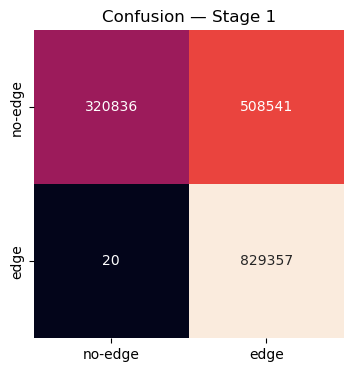


=== Stage 2: Task2 ===
  Epoch  1, loss: 0.5472
  Epoch 25, loss: 0.5458
  Epoch 50, loss: 0.5414
  → Acc task 1 after stage 2: 64.31%
  → Acc task 2 after stage 2: 64.32%


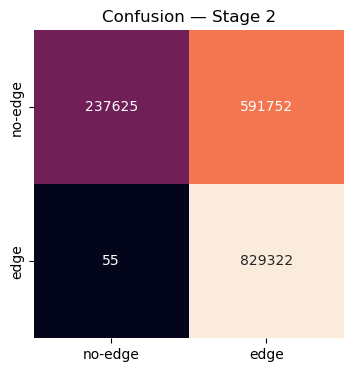


=== Stage 3: Task3 ===
  Epoch  1, loss: 0.5262
  Epoch 25, loss: 0.5039
  Epoch 50, loss: 0.4835
  → Acc task 1 after stage 3: 68.19%
  → Acc task 2 after stage 3: 68.23%
  → Acc task 3 after stage 3: 68.21%


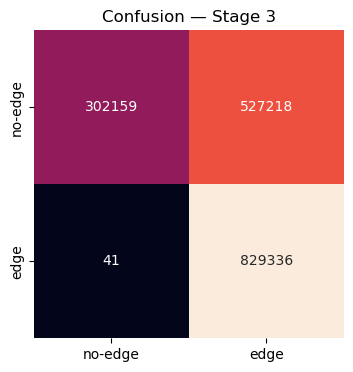


=== Stage 4: Task4 ===
  Epoch  1, loss: 0.4683
  Epoch 25, loss: 0.4571
  Epoch 50, loss: 0.4499
  → Acc task 1 after stage 4: 73.21%
  → Acc task 2 after stage 4: 73.25%
  → Acc task 3 after stage 4: 73.25%
  → Acc task 4 after stage 4: 73.24%


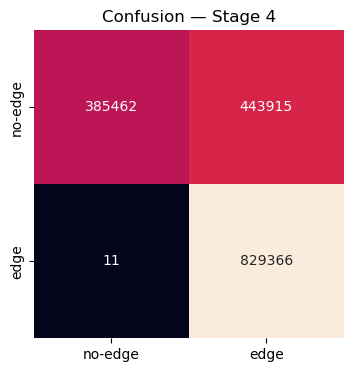


=== Link‐Prediction Acc. per Stage ===
       task_1  task_2  task_3  task_4
Stage                                
1      69.34%    nan%    nan%    nan%
2      64.31%  64.32%    nan%    nan%
3      68.19%  68.23%  68.21%    nan%
4      73.21%  73.25%  73.25%  73.24%


AttributeError: 'numpy.float64' object has no attribute 'DataFrame'

In [6]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# 1. Load & preprocess
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

# build DGL graph
nodes   = df["node"].tolist()
nid2idx = {n:i for i,n in enumerate(nodes)}
N       = len(nodes)

edge_set = set()
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, r in df.iterrows():
    u = nid2idx[r["node"]]
    k = int(r["fan_in"])
    for vname in src_cands[:k]:
        v = nid2idx[vname]
        edge_set.add((u,v))
src_arr = np.array([u for u,_ in edge_set])
dst_arr = np.array([v for _,v in edge_set])

g = dgl.graph((torch.tensor(src_arr), torch.tensor(dst_arr)), num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"] = torch.tensor(df[feat_cols].values, dtype=torch.float32)

# ------------------------------------------------
# 2. Make 4 *random* link‐prediction tasks
# ------------------------------------------------
all_pos = np.column_stack([src_arr, dst_arr])
np.random.shuffle(all_pos)
chunks = np.array_split(all_pos, 4)  # exactly 4 tasks

tasks = []
for i, chunk in enumerate(chunks, start=1):
    n = len(chunk)
    if n < 10:
        # too few edges, skip or combine—but here we just warn
        print(f"Warning: Task {i} has only {n} edges.")
    # 80/20 split
    perm  = np.random.permutation(n)
    split = int(0.8*n)
    pos_tr, pos_te = chunk[perm[:split]], chunk[perm[split:]]
    # sample negatives of equal size
    neg = []
    pos_set = set(map(tuple, chunk.tolist()))
    while len(neg) < n:
        u = np.random.randint(0, N)
        v = np.random.randint(0, N)
        if u!=v and (u,v) not in pos_set:
            neg.append((u,v))
    neg = np.array(neg)
    neg_tr, neg_te = neg[perm[:split]], neg[perm[split:]]
    tasks.append({
        "name":       f"Task{i}",
        "train_pos":  pos_tr,  "train_neg": neg_tr,
        "test_pos":   pos_te,  "test_neg":  neg_te
    })

# ------------------------------------------------
# 3. GCN encoder + EWC helper
# ------------------------------------------------
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid, hid,   allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

class EWC:
    def __init__(self, model, g, task, device):
        self.device = device
        # snapshot
        self.params = {n: p.clone().detach().to(device)
                       for n,p in model.named_parameters()}
        # fisher
        self.fisher = {n: torch.zeros_like(p,device=device)
                       for n,p in model.named_parameters()}
        self._compute_fisher(model, g, task)

    def _compute_fisher(self, model, g, task):
        model.eval()
        P = torch.tensor(task["train_pos"], dtype=torch.long, device=self.device)
        N = torch.tensor(task["train_neg"], dtype=torch.long, device=self.device)
        pairs  = torch.cat([P,N], dim=0)
        labels = torch.cat([
            torch.ones(len(P), device=self.device),
            torch.zeros(len(N),device=self.device)
        ])
        h      = model(g, g.ndata["feat"].to(self.device))
        logits = (h[pairs[:,0]] * h[pairs[:,1]]).sum(dim=1)
        prob   = torch.sigmoid(logits)
        loss   = F.binary_cross_entropy(prob, labels)
        model.zero_grad(); loss.backward()
        for n,p in model.named_parameters():
            if p.grad is not None:
                self.fisher[n] = p.grad.detach()**2

    def penalty(self, model):
        loss = 0
        for n,p in model.named_parameters():
            loss += (self.fisher[n]*(p-self.params[n])**2).sum()
        return loss

# ------------------------------------------------
# 4. Train + evaluate under EWC
# ------------------------------------------------
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc         = GCNEnc(len(feat_cols), 64).to(device)
opt         = optim.Adam(enc.parameters(), lr=1e-2)
ewc_list    = []
λ           = 1000.0
results     = {}
param_snaps = []
fishers     = []

for t, task in enumerate(tasks, start=1):
    print(f"\n=== Stage {t}: {task['name']} ===")

    # build full‐batch training set
    Ptr = torch.tensor(task["train_pos"], dtype=torch.long, device=device)
    Ntr = torch.tensor(task["train_neg"], dtype=torch.long, device=device)
    pairs  = torch.cat([Ptr, Ntr], dim=0)
    labels = torch.cat([
        torch.ones(len(Ptr)), torch.zeros(len(Ntr))
    ], dim=0).to(device)

    # train 50 epochs (we report at 1/25/50)
    for epoch in (1, 25, 50):
        enc.train()
        perm = torch.randperm(len(labels), device=device)
        ups  = pairs[perm,0]; vps = pairs[perm,1]
        h    = enc(g, g.ndata["feat"].to(device))
        logit = (h[ups] * h[vps]).sum(dim=1)
        loss  = F.binary_cross_entropy_with_logits(logit, labels[perm])
        if ewc_list:
            penalty = sum(e.penalty(enc) for e in ewc_list)
            loss = loss + (λ/2)*penalty
        opt.zero_grad(); loss.backward(); opt.step()
        print(f"  Epoch {epoch:2d}, loss: {loss.item():.4f}")

    # snapshot for EWC
    fishers.append(EWC(enc, g, task, device))
    param_snaps.append({n: p.clone().detach().cpu()
                        for n,p in enc.named_parameters()})

    # evaluate on all seen tasks
    enc.eval()
    with torch.no_grad():
        h = enc(g, g.ndata["feat"].to(device))
    accs = {}
    for k, prev in enumerate(tasks[:t], start=1):
        Pte = prev["test_pos"]; Nte = prev["test_neg"]
        Pte = torch.tensor(Pte, dtype=torch.long, device=device)
        Nte = torch.tensor(Nte, dtype=torch.long, device=device)
        ups1 = Pte[:,0]; vps1 = Pte[:,1]
        ups2 = Nte[:,0]; vps2 = Nte[:,1]
        prob_pos = torch.sigmoid((h[ups1]*h[vps1]).sum(dim=1)).cpu().numpy()
        prob_neg = torch.sigmoid((h[ups2]*h[vps2]).sum(dim=1)).cpu().numpy()
        preds    = np.concatenate([prob_pos>0.5, prob_neg>0.5]).astype(int)
        labs     = np.concatenate([np.ones(len(ups1)), np.zeros(len(ups2))])
        accs[f"task_{k}"] = accuracy_score(labs, preds)
        print(f"  → Acc task {k} after stage {t}: {accs[f'task_{k}']*100:.2f}%")
    results[t] = accs

    # confusion matrix for this stage
    labs_te = np.concatenate([np.ones(len(Nte))*0,
                              np.ones(len(ups1))])  # careful ordering
    labs_te = np.concatenate([np.ones(len(ups1)), np.zeros(len(ups2))])  
    probs   = np.concatenate([prob_pos, prob_neg])
    cm      = confusion_matrix(labs_te, (probs>0.5).astype(int))
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False,
                xticklabels=["no‐edge","edge"],
                yticklabels=["no‐edge","edge"])
    plt.title(f"Confusion — Stage {t}")
    plt.show()

# ------------------------------------------------
# 5. Summary of link‐pred accuracies
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Link‐Prediction Acc. per Stage ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# ------------------------------------------------
# 6. Interpretability Dashboard
# ------------------------------------------------
drifts = []
for t in range(2, len(param_snaps)+1):
    θ_t = param_snaps[t-1]
    for k in range(1, t):
        θ_k   = param_snaps[k-1]
        F_k   = fishers[k-1].fisher
        # param‐drift
        pd2 = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd  = np.sqrt(pd2)
        # EWC‐drift
        ed  = sum((F_k[n].cpu()*(θ_t[n]-θ_k[n])**2).sum().item() for n in θ_k)
        # forgetting ΔAcc
        a_kk = results[k][f"task_{k}"]
        a_kt = results[t][f"task_{k}"]
        da   = a_kk - a_kt
        drifts.append({
            "from_task":   k,
            "to_task":     t,
            "param_drift": pd,
            "ewc_drift":   ed,
            "delta_acc":   da
        })

dash = pd.DataFrame(drifts)
dash["from_to"] = dash["from_task"].astype(str)+"→"+dash["to_task"].astype(str)
print("\n=== Dashboard: Drift vs Forgetting ===")
print(dash[["from_to","param_drift","ewc_drift","delta_acc"]])
print(f"\nCorr param drift vs ΔAcc: {dash.param_drift.corr(dash.delta_acc):.4f}")
print(f"Corr EWC drift vs ΔAcc:   {dash.ewc_drift.corr(dash.delta_acc):.4f}")


In [7]:
# ------------------------------------------------
# Interpretability Dashboard (corrected)
# ------------------------------------------------
import numpy as np
import pandas as _pd   # use a fresh alias to avoid any pd shadowing

# Build drift records
records = []
for t in range(2, len(param_snaps) + 1):
    state_t = param_snaps[t-1]
    for k in range(1, t):
        state_k = param_snaps[k-1]
        Fk = fishers[k-1].fisher

        # 1) Parameter drift ‖θ_t − θ_k‖₂
        sq = sum((state_t[n] - state_k[n]).pow(2).sum().item() for n in state_k)
        param_drift = np.sqrt(sq)

        # 2) EWC‐weighted drift
        ewc_drift = sum((Fk[n].cpu() * (state_t[n] - state_k[n])**2).sum().item()
                        for n in state_k)

        # 3) Forgetting ΔAcc = Acc_k(k) − Acc_k(t)
        acc_kk = results[k].get(f"task_{k}", 0.0)
        acc_kt = results[t].get(f"task_{k}", 0.0)
        delta_acc = acc_kk - acc_kt

        records.append({
            "from_task":   k,
            "to_task":     t,
            "param_drift": param_drift,
            "ewc_drift":   ewc_drift,
            "delta_acc":   delta_acc
        })

# Create DataFrame
dashboard = _pd.DataFrame(records)

if not dashboard.empty:
    # Vectorized label
    dashboard["from_to"] = (
        dashboard["from_task"].astype(int).astype(str)
        + "→" +
        dashboard["to_task"].astype(int).astype(str)
    )

    # Print table
    print("\n=== Dashboard: Drift vs Forgetting ===")
    print(dashboard[["from_to","param_drift","ewc_drift","delta_acc"]])

    # Compute correlations
    corr_pd  = dashboard["param_drift"].corr(dashboard["delta_acc"])
    corr_ewc = dashboard["ewc_drift"].corr(dashboard["delta_acc"])
    print(f"\nCorrelation (param drift vs ΔAcc): {corr_pd:.4f}")
    print(f"Correlation (EWC drift vs ΔAcc):   {corr_ewc:.4f}")
else:
    print("Not enough task pairs for Interpretability Dashboard.")



=== Dashboard: Drift vs Forgetting ===
  from_to  param_drift  ewc_drift  delta_acc
0     1→2     0.861579   0.000036   0.050262
1     1→3     1.389111   0.000107   0.011492
2     2→3     0.687071   0.000026  -0.039058
3     1→4     1.765522   0.000169  -0.038701
4     2→4     1.211488   0.000094  -0.089307
5     3→4     0.586988   0.000006  -0.050338

Correlation (param drift vs ΔAcc): -0.0445
Correlation (EWC drift vs ΔAcc):   -0.1212


#### Parameter Regularization: SI


=== Stage 1: Task1 ===
  Epoch 01, loss: 0.9307
  Epoch 10, loss: 0.5686
  Epoch 50, loss: 0.5075
  → Acc task 1 after stage 1: 72.21%


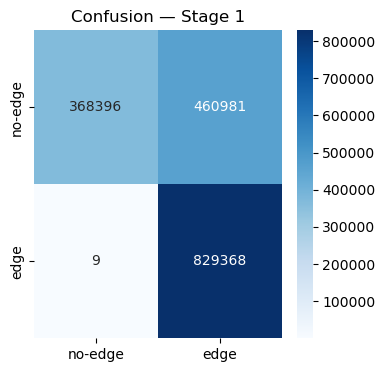


=== Stage 2: Task2 ===
  Epoch 01, loss: 0.5265
  Epoch 10, loss: 0.5878
  Epoch 50, loss: 0.5145
  → Acc task 1 after stage 2: 70.43%
  → Acc task 2 after stage 2: 70.46%


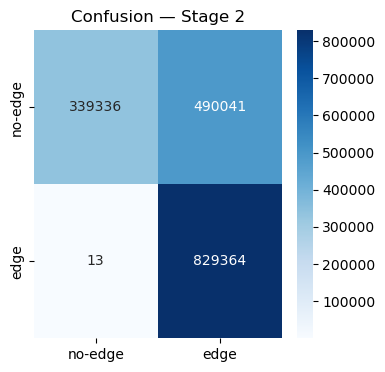


=== Stage 3: Task3 ===
  Epoch 01, loss: 0.4912
  Epoch 10, loss: 0.4987
  Epoch 50, loss: 0.4949
  → Acc task 1 after stage 3: 76.53%
  → Acc task 2 after stage 3: 76.58%
  → Acc task 3 after stage 3: 76.56%


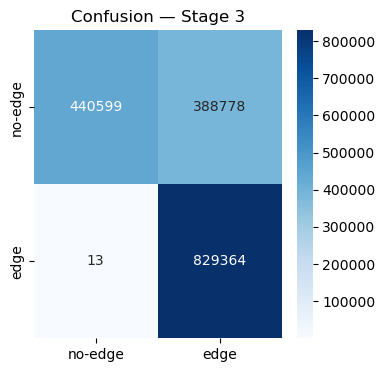


=== Stage 4: Task4 ===
  Epoch 01, loss: 0.4565
  Epoch 10, loss: 0.4616
  Epoch 50, loss: 0.4648
  → Acc task 1 after stage 4: 77.66%
  → Acc task 2 after stage 4: 77.67%
  → Acc task 3 after stage 4: 77.66%
  → Acc task 4 after stage 4: 77.70%


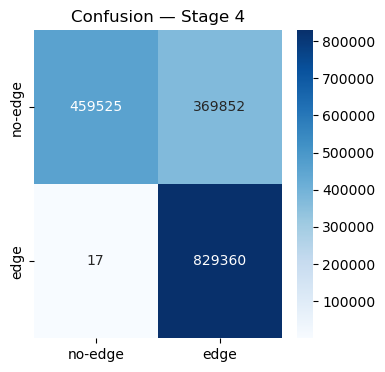


=== Link‐Pred Accuracies per Stage ===
       task_1  task_2  task_3  task_4
Stage                                
1      72.21%    nan%    nan%    nan%
2      70.43%  70.46%    nan%    nan%
3      76.53%  76.58%  76.56%    nan%
4      77.66%  77.67%  77.66%  77.70%

=== SI Dashboard: Drift vs Forgetting ===
  from_to  param_drift  si_drift  delta_acc
0     1→2     0.705804 -0.000162   0.017781
1     1→3     1.118743 -0.000368  -0.043248
2     2→3     0.616743 -0.000009  -0.061201
3     1→4     1.289030 -0.000289  -0.054493
4     2→4     0.961438 -0.000121  -0.072131
5     3→4     0.461007 -0.000008  -0.010967

Corr(param drift vs ΔAcc): -0.4727
Corr(si drift vs ΔAcc):    0.0956


In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
import pandas as pd
df = pd.read_csv("all_circuits_features.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

# build DGL graph
nodes   = df["node"].tolist()
nid2idx = {n:i for i,n in enumerate(nodes)}
N       = len(nodes)

edge_set = set()
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, r in df.iterrows():
    u = nid2idx[r["node"]]
    k = int(r["fan_in"])
    for vname in src_cands[:k]:
        v = nid2idx[vname]
        edge_set.add((u, v))

# arrays of all positive edges
pos_all = np.array(list(edge_set))

# ------------------------------------------------
# 2. Split into 4 tasks (randomly)
# ------------------------------------------------
np.random.shuffle(pos_all)
chunks = np.array_split(pos_all, 4)  # 4 tasks

tasks = []
for i, pos in enumerate(chunks, start=1):
    name = f"Task{i}"
    n    = len(pos)
    if n == 0:
        raise ValueError(f"No edges in {name}")
    perm  = np.random.permutation(n)
    split = int(0.8 * n)
    pos_tr = pos[perm[:split]]
    pos_te = pos[perm[split:]]
    # sample negatives equal to n
    pos_set = set(map(tuple, pos.tolist()))
    neg = []
    while len(neg) < n:
        u = np.random.randint(0, N)
        v = np.random.randint(0, N)
        if u != v and (u,v) not in pos_set:
            neg.append((u,v))
    neg = np.array(neg)
    neg_tr = neg[perm[:split]]
    neg_te = neg[perm[split:]]
    tasks.append({
        "name":      name,
        "train_pos": pos_tr, "train_neg": neg_tr,
        "test_pos":  pos_te, "test_neg":  neg_te
    })

# build DGL once
src_arr = pos_all[:,0]
dst_arr = pos_all[:,1]
g = dgl.graph((torch.tensor(src_arr), torch.tensor(dst_arr)), num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"] = torch.tensor(df[feat_cols].values, dtype=torch.float32)

# ------------------------------------------------
# 3. GCN encoder + dot‐product decoder
# ------------------------------------------------
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid, hid,   allow_zero_in_degree=True)
    def forward(self, graph, x):
        h = torch.relu(self.conv1(graph, x))
        return self.conv2(graph, h)

# ------------------------------------------------
# 4. Synaptic Intelligence
# ------------------------------------------------
class SynapticIntelligence:
    def __init__(self, model, xi=0.1):
        self.xi = xi
        # total importance
        self.omega = {n: torch.zeros_like(p.data)
                      for n,p in model.named_parameters() if p.requires_grad}
        # snapshot after last task
        self.theta_old = {n: p.data.clone().detach()
                          for n,p in model.named_parameters() if p.requires_grad}

    def begin_task(self, model):
        self.prev_theta = {n: p.data.clone().detach()
                           for n,p in model.named_parameters() if p.requires_grad}
        self.path_omega = {n: torch.zeros_like(p.data)
                           for n,p in model.named_parameters() if p.requires_grad}

    def accumulate(self, model):
        for n,p in model.named_parameters():
            if not p.requires_grad: continue
            grad  = p.grad.data
            delta = p.data - self.prev_theta[n]
            self.path_omega[n] += - grad * delta
            self.prev_theta[n] = p.data.clone().detach()

    def end_task(self, model):
        for n,p in model.named_parameters():
            if not p.requires_grad: continue
            delta = p.data - self.theta_old[n]
            denom = delta.pow(2) + self.xi
            omega_task = self.path_omega[n] / denom
            self.omega[n] += omega_task
            self.theta_old[n] = p.data.clone().detach()

    def penalty(self, model):
        loss = 0
        for n,p in model.named_parameters():
            if not p.requires_grad: continue
            loss += (self.omega[n] * (p - self.theta_old[n]).pow(2)).sum()
        return loss

# ------------------------------------------------
# 5. Training loop w/ SI
# ------------------------------------------------
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc       = GCNEnc(len(feat_cols), hid=64).to(device)
opt       = optim.Adam(enc.parameters(), lr=1e-2)
si        = SynapticIntelligence(enc, xi=0.1)
lambda_si = 1000.0
results   = {}
# snapshots
theta_snaps = []
omega_snaps = []

for stage, task in enumerate(tasks, start=1):
    print(f"\n=== Stage {stage}: {task['name']} ===")
    # prepare data
    P = torch.tensor(task["train_pos"], dtype=torch.long, device=device)
    Nn= torch.tensor(task["train_neg"], dtype=torch.long, device=device)
    pairs  = torch.cat([P, Nn], dim=0)
    labels = torch.cat([
        torch.ones(len(P)), torch.zeros(len(Nn))
    ], dim=0).to(device)

    # begin SI for this task
    si.begin_task(enc)
    enc.train()
    for epoch in (1,10,50):
        opt.zero_grad()
        h    = enc(g, g.ndata["feat"].to(device))
        logits = (h[pairs[:,0]] * h[pairs[:,1]]).sum(dim=1)
        loss   = F.binary_cross_entropy_with_logits(logits, labels)
        if stage > 1:
            loss = loss + lambda_si * si.penalty(enc)
        loss.backward()
        si.accumulate(enc)
        opt.step()
        print(f"  Epoch {epoch:02d}, loss: {loss.item():.4f}")

    # end SI for this task
    si.end_task(enc)
    # snapshot
    theta_snaps.append({n: p.clone().detach().cpu()
                        for n,p in enc.named_parameters()})
    omega_snaps.append({n: v.clone().cpu() for n,v in si.omega.items()})

    # evaluate on all seen tasks
    enc.eval()
    with torch.no_grad():
        h = enc(g, g.ndata["feat"].to(device))
    accs = {}
    for k, prev in enumerate(tasks[:stage], start=1):
        Pte = torch.tensor(prev["test_pos"], dtype=torch.long, device=device)
        Nte = torch.tensor(prev["test_neg"], dtype=torch.long, device=device)
        ups1,vps1 = Pte[:,0], Pte[:,1]
        ups2,vps2 = Nte[:,0], Nte[:,1]
        prob_pos = torch.sigmoid((h[ups1]*h[vps1]).sum(dim=1)).cpu().numpy()
        prob_neg = torch.sigmoid((h[ups2]*h[vps2]).sum(dim=1)).cpu().numpy()
        preds    = np.concatenate([prob_pos>0.5, prob_neg>0.5]).astype(int)
        labs     = np.concatenate([np.ones(len(ups1)), np.zeros(len(ups2))])
        accs[f"task_{k}"] = accuracy_score(labs, preds)
        print(f"  → Acc task {k} after stage {stage}: {accs[f'task_{k}']*100:.2f}%")
    results[stage] = accs

    # confusion matrix for this task
    labs_te = np.concatenate([np.ones(len(prev["test_pos"])),
                              np.zeros(len(prev["test_neg"]))])
    pairs_te = np.vstack([prev["test_pos"], prev["test_neg"]])
    ups_te = torch.tensor(pairs_te[:,0], device=device)
    vps_te = torch.tensor(pairs_te[:,1], device=device)
    with torch.no_grad():
        probs = torch.sigmoid((h[ups_te]*h[vps_te]).sum(dim=1)).cpu().numpy()
    preds = (probs>0.5).astype(int)
    cm    = confusion_matrix(labs_te, preds)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["no‐edge","edge"],
                yticklabels=["no‐edge","edge"])
    plt.title(f"Confusion — Stage {stage}")
    plt.show()

# ------------------------------------------------
# 6. Summary of link‐prediction accuracies
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Link‐Pred Accuracies per Stage ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# ------------------------------------------------
# 7. Interpretability Dashboard for SI
# ------------------------------------------------
import pandas as pd2

records = []
num_tasks = len(theta_snaps)
for t in range(2, num_tasks+1):
    θ_t = theta_snaps[t-1]
    for k in range(1, t):
        θ_k = theta_snaps[k-1]
        Ω_k = omega_snaps[k-1]
        # param drift
        sq = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd_ = np.sqrt(sq)
        # SI‐weighted drift
        sid = sum((Ω_k[n] * (θ_t[n]-θ_k[n])**2).sum().item() for n in θ_k)
        # forgetting
        a_kk = results[k][f"task_{k}"]
        a_kt = results[t][f"task_{k}"]
        da   = a_kk - a_kt
        records.append({
            "from_task":   k,
            "to_task":     t,
            "param_drift": pd_,
            "si_drift":    sid,
            "delta_acc":   da
        })

dash = pd2.DataFrame(records)
if not dash.empty:
    dash["from_to"] = (
        dash["from_task"].astype(int).astype(str)
        + "→" +
        dash["to_task"].astype(int).astype(str)
    )
    print("\n=== SI Dashboard: Drift vs Forgetting ===")
    print(dash[["from_to","param_drift","si_drift","delta_acc"]])
    print(f"\nCorr(param drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")
    print(f"Corr(si drift vs ΔAcc):    {dash.si_drift.corr(dash.delta_acc):.4f}")
else:
    print("Not enough task pairs to build SI dashboard.")


#### Replay-based Methods (a.k.a. Experience Replay):iCaRL (Incremental Classifier and Representation Learning)


=== Stage1: ['and', 'or'] ===
 Ep1, loss 0.9100
 Ep10, loss 0.5114
 Ep50, loss 0.4395
  Acc task1: 64.75%


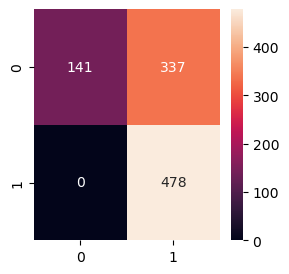


=== Stage2: ['nand', 'nor'] ===
 Ep1, loss 0.4440
 Ep10, loss 1.9341
 Ep50, loss 9.4702
  Acc task1: 64.12%


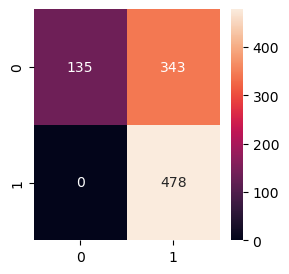

  Acc task2: 75.00%


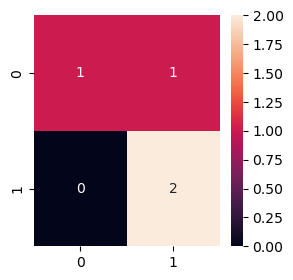


=== Stage3: ['xor', 'xnor'] ===
 Ep1, loss 0.4564
 Ep10, loss 4.4453
 Ep50, loss 0.5526
  Acc task1: 65.38%


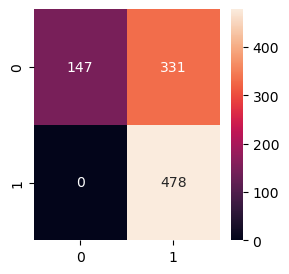

  Acc task2: 75.00%


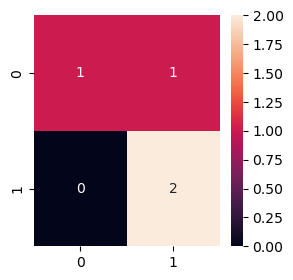

  Acc task3: 75.00%


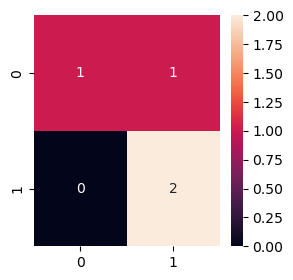


=== Stage4: ['buf', 'not'] ===
 Ep1, loss 0.4760
 Ep10, loss 1.0786
 Ep50, loss 1.4385
  Acc task1: 63.60%


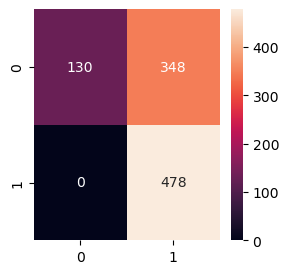

  Acc task2: 50.00%


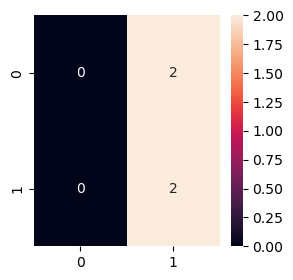

  Acc task3: 75.00%


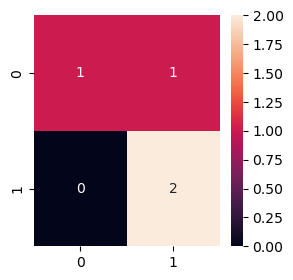

  Acc task4: 61.32%


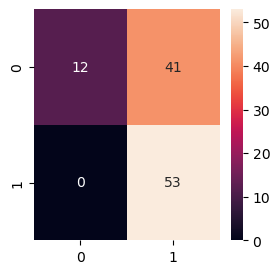

        task1   task2   task3   task4
Stage                                
1      64.75%    nan%    nan%    nan%
2      64.12%  75.00%    nan%    nan%
3      65.38%  75.00%  75.00%    nan%
4      63.60%  50.00%  75.00%  61.32%
  task        pd         dl        da
0  1→2  0.579191   1.713462  0.006276
1  1→3  0.732453   5.899275 -0.006276
2  2→3  0.286810   1.104511  0.000000
3  1→4  0.888302  10.390121  0.011506
4  2→4  0.640788   3.233203  0.250000
5  3→4  0.395992   0.510963  0.000000


In [12]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Load & preprocess
df = pd.read_csv("all_circuits_features.csv")
feat_cols = ["fan_in","fan_out","dist_to_output","is_primary_input",
             "is_primary_output","is_internal","is_key_gate",
             "degree_centrality","betweenness_centrality",
             "closeness_centrality","clustering_coefficient",
             "avg_fan_in_neighbors","avg_fan_out_neighbors"]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

# Build base graph
nodes   = df["node"].tolist()
nid2idx = {n:i for i,n in enumerate(nodes)}
N       = len(nodes)
edges = set()
src_cands = df[df["fan_out"]>0]["node"]
for _, r in df.iterrows():
    u = nid2idx[r["node"]]; k = int(r["fan_in"])
    for vname in src_cands[:k]:
        v = nid2idx[vname]; edges.add((u,v))
pos_all = np.array(list(edges))

g = dgl.graph((torch.tensor(pos_all[:,0]), torch.tensor(pos_all[:,1])),
              num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"] = torch.tensor(df[feat_cols].values, dtype=torch.float32)

# 2) Define 4 tasks by gate‐type groups
group_defs = [["and","or"],["nand","nor"],["xor","xnor"],["buf","not"]]
tasks = []
for grp in group_defs:
    # positive edges within grp
    mask = df["gate_type"].isin(grp).to_numpy()
    idxs = np.where(mask)[0]
    mpos = np.isin(pos_all[:,0], idxs) & np.isin(pos_all[:,1], idxs)
    pos = pos_all[mpos]
    # force at least a few edges
    if len(pos) < 5:
        pos = pos_all[np.random.choice(len(pos_all), 10, replace=False)]
    n = len(pos)
    perm = np.random.permutation(n)
    split = int(0.8*n)
    tasks.append({
        "name": f"{grp}",
        "train_pos": pos[perm[:split]],
        "test_pos":  pos[perm[split:]]
    })

# add negatives equal to positives
for t in tasks:
    pos = t["train_pos"]
    n   = len(pos)
    neg = set()
    while len(neg)<n:
        u = random.randrange(N); v = random.randrange(N)
        if u!=v and (u,v) not in edges:
            neg.add((u,v))
    t["train_neg"] = np.array(list(neg))
    # same for test
    pos_te = t["test_pos"]; m = len(pos_te)
    neg_te = set()
    while len(neg_te)<m:
        u,v = random.randrange(N), random.randrange(N)
        if u!=v and (u,v) not in edges:
            neg_te.add((u,v))
    t["test_neg"] = np.array(list(neg_te))

# 3) GCN encoder
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.c1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.c2 = dglnn.GraphConv(hid, hid,   allow_zero_in_degree=True)
    def forward(self, g, x):
        h = F.relu(self.c1(g, x)); return self.c2(g, h)

# 4) iCaRL replay + distill
memory, results = [], {}
param_snaps, embed_snaps, mem_snaps = [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc    = GCNEnc(len(feat_cols), 64).to(device)
opt    = optim.Adam(enc.parameters(), lr=1e-2)

old_enc = None
for stage, t in enumerate(tasks, start=1):
    print(f"\n=== Stage{stage}: {t['name']} ===")
    # build train set
    P = [(u,v,1) for u,v in t["train_pos"]]
    Nn= [(u,v,0) for u,v in t["train_neg"]]
    data = P+Nn+memory

    us = torch.tensor([u for u,_,_ in data], dtype=torch.long, device=device)
    vs = torch.tensor([v for _,v,_ in data], dtype=torch.long, device=device)
    lb = torch.tensor([l for _,_,l in data], dtype=torch.float32, device=device)

    # distill on memory if available
    if old_enc and memory:
        with torch.no_grad():
            h_old = old_enc(g, g.ndata["feat"].to(device))
            mus = torch.tensor([u for u,_,_ in memory], device=device)
            mvs = torch.tensor([v for _,v,_ in memory], device=device)
            old_score = (h_old[mus]*h_old[mvs]).sum(dim=1)

    enc.train()
    for ep in (1,10,50):
        opt.zero_grad()
        h = enc(g, g.ndata["feat"].to(device))
        sc = (h[us]*h[vs]).sum(dim=1)
        loss = F.binary_cross_entropy_with_logits(sc, lb)
        if old_enc and memory:
            new_sc = (h[mus]*h[mvs]).sum(dim=1)
            loss += F.mse_loss(new_sc, old_score)
        loss.backward(); opt.step()
        print(f" Ep{ep}, loss {loss.item():.4f}")

    # update memory w/ new data
    memory += random.sample(P+Nn, min(100,len(P+Nn)))
    mem_snaps.append(list(memory))

    # snapshots
    param_snaps.append({n:p.cpu().clone() for n,p in enc.named_parameters()})
    with torch.no_grad():
        embed_snaps.append(enc(g,g.ndata["feat"].to(device)).cpu())

    # eval
    enc.eval()
    with torch.no_grad():
        h = enc(g, g.ndata["feat"].to(device))
    res = {}
    for k in range(stage):
        Pte = tasks[k]["test_pos"]; Nte = tasks[k]["test_neg"]
        us2 = torch.tensor(Pte[:,0], device=device); vs2 = torch.tensor(Pte[:,1], device=device)
        us3 = torch.tensor(Nte[:,0], device=device); vs3 = torch.tensor(Nte[:,1], device=device)
        scp = torch.sigmoid((h[us2]*h[vs2]).sum(1)).cpu().numpy()
        scn = torch.sigmoid((h[us3]*h[vs3]).sum(1)).cpu().numpy()
        pred = np.concatenate([scp>0.5, scn>0.5]).astype(int)
        lab  = np.concatenate([np.ones(len(scp)), np.zeros(len(scn))])
        acc = accuracy_score(lab, pred); res[f"task{k+1}"] = acc
        print(f"  Acc task{k+1}: {acc*100:.2f}%")
        cm = confusion_matrix(lab, pred)
        plt.figure(figsize=(3,3)); sns.heatmap(cm,annot=True,fmt="d"); plt.show()
    results[stage]=res
    old_enc = copy.deepcopy(enc).eval().to(device)

# summarize
df_res = pd.DataFrame(results).T; df_res.index.name="Stage"
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# dashboard
records=[]
for t in range(2, len(param_snaps)+1):
    pt = param_snaps[t-1]; et=embed_snaps[t-1]
    for k in range(1,t):
        pk= param_snaps[k-1]; ek=embed_snaps[k-1]; mk=mem_snaps[k-1]
        # param drift
        sq=sum((pt[n]-pk[n]).pow(2).sum().item() for n in pk)
        pd_=np.sqrt(sq)
        # distill loss on mk
        if mk:
            us4=np.array([u for u,_,_ in mk]); vs4=np.array([v for _,v,_ in mk])
            dt = F.mse_loss((et[us4]*et[vs4]).sum(1),(ek[us4]*ek[vs4]).sum(1)).item()
        else:
            dt=np.nan
        da=results[k][f"task{k}"]-results[t][f"task{k}"]
        records.append({"from":k,"to":t,"pd":pd_,"dl":dt,"da":da})
dash=pd.DataFrame(records)
dash["task"]=dash["from"].astype(str)+"→"+dash["to"].astype(str)
print(dash[["task","pd","dl","da"]])


#### Hybrid: Meta-Experience Replay (MER)
    -Combines experience replay with meta-gradient optimization.


=== Stage 1: learning ['and', 'or'] ===
  Epoch 01, loss_new: 2.2546
  Epoch 10, loss_new: 1.0032
  Epoch 50, loss_new: 0.5267
  → Acc group 1 ['and', 'or']: 72.80%


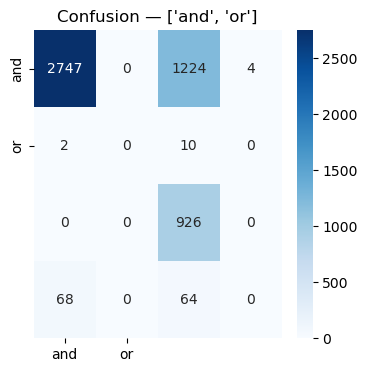


=== Stage 2: learning ['nand', 'nor'] ===
  Epoch 01, loss_new: 5.9234
  Epoch 10, loss_new: 2.1332
  Epoch 50, loss_new: 0.9239
  → Acc group 1 ['and', 'or']: 72.07%
  → Acc group 2 ['nand', 'nor']: 49.63%


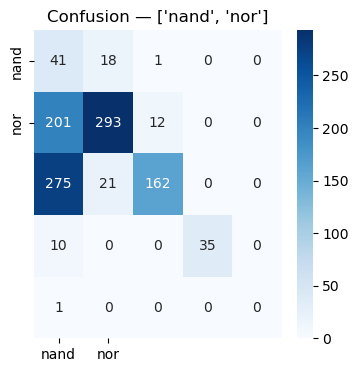


=== Stage 3: learning ['xor'] ===
  Epoch 01, loss_new: 37.8116
  Epoch 10, loss_new: 0.5836
  Epoch 50, loss_new: 0.4666
  → Acc group 1 ['and', 'or']: 57.34%
  → Acc group 2 ['nand', 'nor']: 71.40%
  → Acc group 3 ['xor']: 68.00%


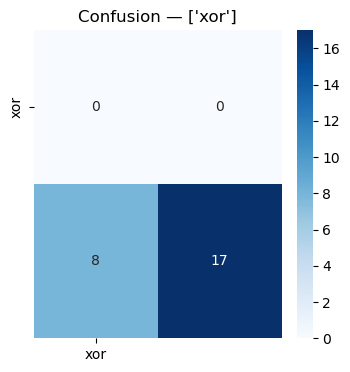


=== Stage 4: learning ['not'] ===
  Epoch 01, loss_new: 0.5745
  Epoch 10, loss_new: 0.5455
  Epoch 50, loss_new: 0.4450
  → Acc group 1 ['and', 'or']: 70.55%
  → Acc group 2 ['nand', 'nor']: 45.98%
  → Acc group 3 ['xor']: 68.00%
  → Acc group 4 ['not']: 83.69%


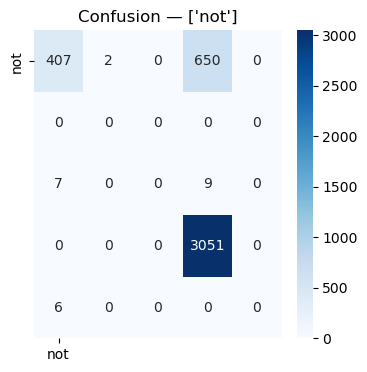


=== Accuracies per stage & group ===
      group_1 group_2 group_3 group_4
Stage                                
1      72.80%    nan%    nan%    nan%
2      72.07%  49.63%    nan%    nan%
3      57.34%  71.40%  68.00%    nan%
4      70.55%  45.98%  68.00%  83.69%


AttributeError: 'numpy.float64' object has no attribute 'DataFrame'

In [13]:
import random
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load & preprocess data
# -----------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes   = df["node"].tolist()
node2idx = {n:i for i,n in enumerate(nodes)}
N = len(nodes)

# -----------------------------
# 2. Build DGL graph
# -----------------------------
edges = set()
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _, r in df.iterrows():
    tgt = node2idx[r["node"]]
    k   = int(r["fan_in"])
    for s in src_cands[:k]:
        edges.add((node2idx[s], tgt))
src, dst = zip(*edges) if edges else ([],[])
g = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
g.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# -----------------------------
# 3. Define 4 classification tasks
# -----------------------------
group_defs = [
    ["and","or"],
    ["nand","nor"],
    ["xor","xnor"],
    ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [gtype for gtype in grp if gtype in all_types]
    if not present:
        continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42)
    tm = torch.zeros(N, dtype=torch.bool); tm[tr] = True
    vm = torch.zeros(N, dtype=torch.bool); vm[te] = True
    train_masks.append(tm); test_masks.append(vm)

# -----------------------------
# 4. GCN for node classification
# -----------------------------
class GCN(nn.Module):
    def __init__(self, in_feats, hid, num_cls):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid,   num_cls, allow_zero_in_degree=True)
    def forward(self, graph, x):
        h = F.relu(self.conv1(graph, x))
        return self.conv2(graph, h)

# -----------------------------
# 5. A-GEM helpers
# -----------------------------
def get_grad_vector(params):
    return torch.cat([p.grad.view(-1) for p in params])

def set_grad_vector(params, vec):
    pointer = 0
    for p in params:
        numel = p.numel()
        p.grad.copy_(vec[pointer:pointer+numel].view_as(p))
        pointer += numel

# -----------------------------
# 6. Train w/ A-GEM + snapshot
# -----------------------------
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model          = GCN(len(feat_cols), 64, len(le.classes_)).to(device)
opt            = optim.Adam(model.parameters(), lr=1e-2)
criterion      = nn.CrossEntropyLoss()
graph          = g.to(device)

memory_buffer  = []         # list of node indices
memory_snap    = []
param_snapshots= []
results        = {}

memory_per_task= 200
mem_batch_size = 100

for stage, (tr_mask, te_mask, grp) in enumerate(
        zip(train_masks, test_masks, valid_groups), start=1):
    print(f"\n=== Stage {stage}: learning {grp} ===")
    tr = tr_mask.to(device); te = te_mask.to(device)
    new_idxs = tr.nonzero().squeeze().tolist()
    params = [p for p in model.parameters() if p.requires_grad]

    model.train()
    for epoch in range(1, 51):
        # 1) reference grad on memory
        if memory_buffer:
            mem = random.sample(memory_buffer, min(mem_batch_size, len(memory_buffer)))
            opt.zero_grad()
            logits = model(graph, graph.ndata["feat"])
            loss_mem = criterion(logits[mem], graph.ndata["label"][mem])
            loss_mem.backward()
            g_ref = get_grad_vector(params).clone()

        # 2) compute new-task grad
        opt.zero_grad()
        logits = model(graph, graph.ndata["feat"])
        loss_new = criterion(logits[new_idxs], graph.ndata["label"][new_idxs])
        loss_new.backward()
        g_new = get_grad_vector(params).clone()

        # 3) project if conflict
        if memory_buffer:
            dot = torch.dot(g_new, g_ref)
            if dot < 0:
                g_proj = g_new - dot / (g_ref.dot(g_ref)+1e-12) * g_ref
                set_grad_vector(params, g_proj)

        opt.step()
        if epoch in (1,10,50):
            print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory & snapshots
    sampled = random.sample(new_idxs, min(memory_per_task, len(new_idxs)))
    memory_buffer.extend(sampled)
    memory_snap.append(list(memory_buffer))
    param_snapshots.append({n: p.clone().detach().cpu()
                             for n,p in model.state_dict().items()})

    # evaluate
    model.eval()
    with torch.no_grad():
        logits_full = model(graph, graph.ndata["feat"]).cpu().numpy()
        preds = logits_full.argmax(1)
    results[stage] = {}
    for k in range(stage):
        idxs = test_masks[k].nonzero().squeeze().cpu().numpy()
        y_true = g.ndata["label"][idxs].cpu().numpy()
        y_pred = preds[idxs]
        acc = accuracy_score(y_true, y_pred)
        results[stage][f"group_{k+1}"] = acc
        print(f"  → Acc group {k+1} {valid_groups[k]}: {acc*100:.2f}%")

    cm_idxs = te.nonzero().squeeze().cpu().numpy()
    cm = confusion_matrix(
        g.ndata["label"][cm_idxs].cpu().numpy(), preds[cm_idxs]
    )
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=grp, yticklabels=grp)
    plt.title(f"Confusion — {grp}")
    plt.show()

# -----------------------------
# 7. Summarize results
# -----------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:.2f}%"))

# -----------------------------
# 8. Interpretability Dashboard
# -----------------------------
records = []
num_tasks = len(param_snapshots)

for t in range(2, num_tasks+1):
    # compute new-task gradient g_new_t
    model.zero_grad()
    tr_idxs = train_masks[t-1].nonzero().squeeze().tolist()
    logits = model(graph, graph.ndata["feat"])
    loss_t = criterion(logits[tr_idxs], graph.ndata["label"][tr_idxs])
    loss_t.backward()
    g_new_t = get_grad_vector(params).cpu()

    for k in range(1, t):
        # compute ref gradient g_ref_k on memory_snap[k-1]
        model.zero_grad()
        mem_k = memory_snap[k-1]
        logits_k = model(graph, graph.ndata["feat"])
        loss_k = criterion(logits_k[mem_k], graph.ndata["label"][mem_k])
        loss_k.backward()
        g_ref_k = get_grad_vector(params).cpu()

        # cosine similarity
        cos_sim = torch.dot(g_new_t, g_ref_k)/(g_new_t.norm()*g_ref_k.norm()+1e-12)

        # parameter drift
        θ_t = param_snapshots[t-1]; θ_k = param_snapshots[k-1]
        sq = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        pd = np.sqrt(sq)

        # forgetting ΔAcc_k^(t)
        da = results[k][f"group_{k}"] - results[t][f"group_{k}"]

        records.append({
            "from_task": k, "to_task": t,
            "cos_sim": cos_sim.item(),
            "param_drift": pd,
            "delta_acc": da
        })

dash = pd.DataFrame(records)
dash["from_to"] = dash["from_task"].astype(str)+"→"+dash["to_task"].astype(str)

print("\n=== A-GEM Interpretability ===")
print(dash[["from_to","cos_sim","param_drift","delta_acc"]])
print(f"\nCorr(cos_sim vs ΔAcc):    {dash.cos_sim.corr(dash.delta_acc):.4f}")
print(f"Corr(param_drift vs ΔAcc): {dash.param_drift.corr(dash.delta_acc):.4f}")


In [14]:
# -----------------------------
# 8. Interpretability Dashboard
# -----------------------------
import pandas as _pd    # re-import pandas under a fresh alias
import numpy as _np

# `records` should be a list of dicts:
#   [ {"from_task": k, "to_task": t, "cos_sim": ..., "param_drift": ..., "delta_acc": ...}, ... ]

if not isinstance(records, list):
    raise RuntimeError("`records` must be a list of dicts, got: %r" % type(records))

dashboard = _pd.DataFrame.from_records(records)

if dashboard.empty:
    print("Not enough tasks to build A-GEM dashboard.")
else:
    # Create the “k→t” label
    dashboard["from_to"] = (
        dashboard["from_task"].astype(int).astype(str)
        + "→"
        + dashboard["to_task"].astype(int).astype(str)
    )

    # Print the table
    print("\n=== A-GEM Interpretability: CosineSim / ParamDrift vs Forgetting ===")
    print(dashboard[["from_to","cos_sim","param_drift","delta_acc"]])

    # Compute correlations
    corr_cs = dashboard["cos_sim"].corr(     dashboard["delta_acc"] )
    corr_pd = dashboard["param_drift"].corr(dashboard["delta_acc"])
    print(f"\nCorr(cosine-sim vs ΔAcc):    {corr_cs:.4f}")
    print(f"Corr(param-drift vs ΔAcc):   {corr_pd:.4f}")



=== A-GEM Interpretability: CosineSim / ParamDrift vs Forgetting ===
  from_to   cos_sim  param_drift  delta_acc
0     1→2 -0.902999     7.443749   0.007334
1     1→3 -0.141036     9.373952   0.154609
2     2→3 -0.198858     5.307265  -0.217757
3     1→4  0.605471     9.848869   0.022597
4     2→4 -0.495798     5.867478   0.036449
5     3→4 -0.598094     2.042054   0.000000

Corr(cosine-sim vs ΔAcc):    0.0364
Corr(param-drift vs ΔAcc):   0.4355


#### Hybrid: Meta-Experience Replay (MER)
-Combines experience replay with meta-gradient optimization.


=== Stage 1: ['and', 'or'] ===
  Epoch 01, loss_new: 0.9413
  Epoch 10, loss_new: 0.4717
  Epoch 50, loss_new: 0.5242
  → Acc task 1 after stage 1: 61.28%


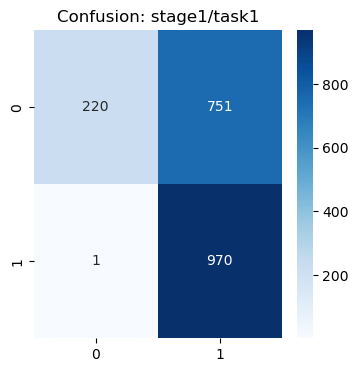


=== Stage 2: ['nand', 'nor'] ===
  Epoch 01, loss_new: 0.5420
  Epoch 10, loss_new: 0.5511
  Epoch 50, loss_new: 1.4851
  → Acc task 1 after stage 2: 67.35%


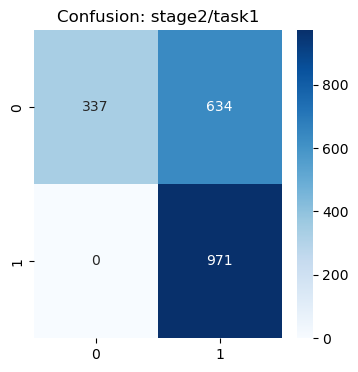

  → Acc task 2 after stage 2: 51.19%


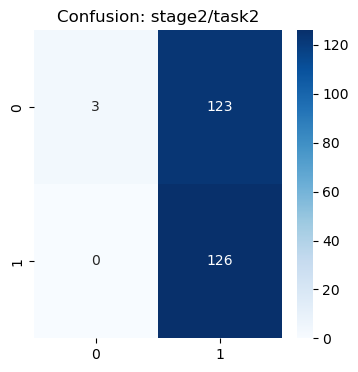


=== Stage 3: ['xor', 'xnor'] ===
  Epoch 01, loss_new: 39.4294
  Epoch 10, loss_new: 38.3630
  Epoch 50, loss_new: 35.8095
  → Acc task 1 after stage 3: 66.63%


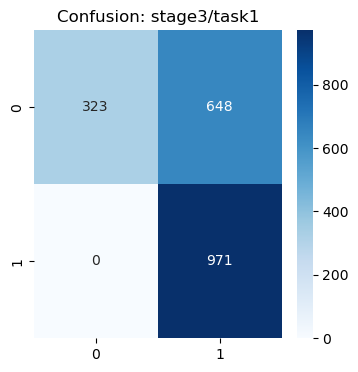

  → Acc task 2 after stage 3: 62.70%


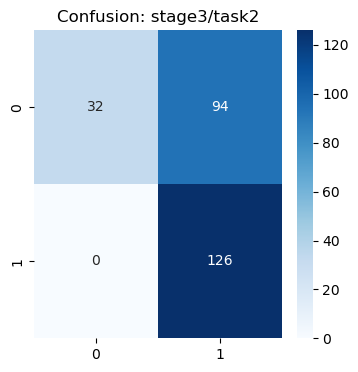

  → Acc task 3 after stage 3: 62.50%


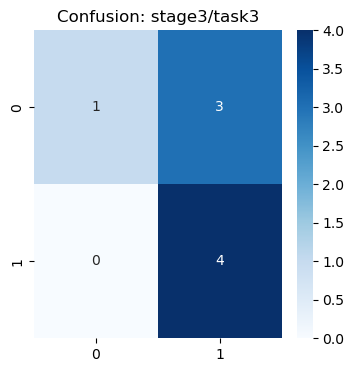


=== Stage 4: ['buf', 'not'] ===
  Epoch 01, loss_new: 0.3882
  Epoch 10, loss_new: 0.4849
  Epoch 50, loss_new: 0.3935
  → Acc task 1 after stage 4: 66.17%


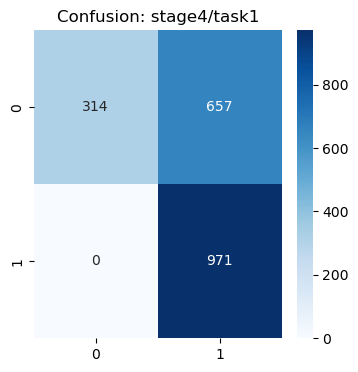

  → Acc task 2 after stage 4: 63.49%


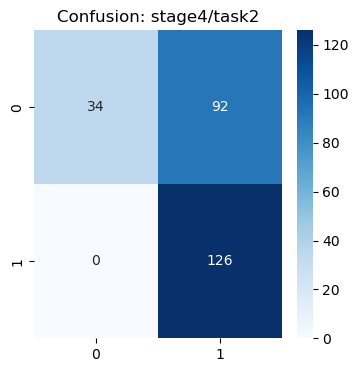

  → Acc task 3 after stage 4: 75.00%


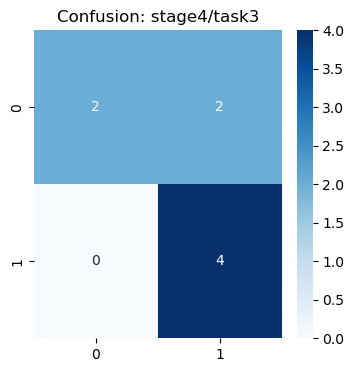

  → Acc task 4 after stage 4: 63.06%


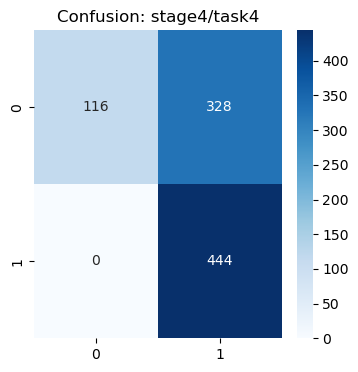


=== Link‐Pred Accuracies ===
       task_1  task_2  task_3  task_4
Stage                                
1      61.28%    nan%    nan%    nan%
2      67.35%  51.19%    nan%    nan%
3      66.63%  62.70%  62.50%    nan%
4      66.17%  63.49%  75.00%  63.06%

=== MER Dashboard: Meta-Drift vs Forgetting ===
  from_to  meta_drift  delta_acc
0     1→2    0.023834  -0.060762
1     1→3    0.168855  -0.053553
2     2→3    0.125834  -0.115079
3     1→4    0.781215  -0.048919
4     2→4    0.712499  -0.123016
5     3→4    0.466599  -0.125000
Corr(meta_drift vs ΔAcc): -0.1566


In [15]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------------------------------
# 1. Load & preprocess
# ---------------------------------------
df = pd.read_csv("all_circuits_features.csv")
feat_cols = [
    "fan_in","fan_out","dist_to_output","is_primary_input",
    "is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes   = df["node"].tolist()
nid2idx = {n:i for i,n in enumerate(nodes)}
N       = len(nodes)

# build base graph
edges = set()
src_cands = df[df["fan_out"]>0]["node"].tolist()
for _,r in df.iterrows():
    u = nid2idx[r["node"]]
    k = int(r["fan_in"])
    for vname in src_cands[:k]:
        v = nid2idx[vname]
        edges.add((u,v))
edges = np.array(list(edges))

g = dgl.graph((torch.tensor(edges[:,0]), torch.tensor(edges[:,1])), num_nodes=N)
g = dgl.add_self_loop(g)
g.ndata["feat"] = torch.tensor(df[feat_cols].values, dtype=torch.float32)

# ---------------------------------------
# 2. Link‐pred tasks by gate‐type
# ---------------------------------------
group_defs = [
    ["and","or"], ["nand","nor"],
    ["xor","xnor"], ["buf","not"]
]
tasks = []
for grp in group_defs:
    idxs = [nid2idx[n] for n in df[df["gate_type"].isin(grp)]["node"]]
    pos = edges[np.isin(edges[:,0], idxs) & np.isin(edges[:,1], idxs)]
    if len(pos)<10:  # if too few, sample random
        pos = edges[np.random.choice(len(edges), 20, replace=False)]
    n = len(pos)
    perm = np.random.permutation(n)
    split = int(0.8*n)
    pos_tr, pos_te = pos[perm[:split]], pos[perm[split:]]
    neg = []
    pos_set = set(map(tuple, pos.tolist()))
    while len(neg)<n:
        u,v = random.choice(idxs), random.choice(idxs)
        if u!=v and (u,v) not in pos_set:
            neg.append((u,v))
    neg = np.array(neg)
    neg_tr, neg_te = neg[perm[:split]], neg[perm[split:]]
    tasks.append({
        "name": grp,
        "train":  np.vstack([np.column_stack([pos_tr, np.ones(len(pos_tr))]),
                             np.column_stack([neg_tr, np.zeros(len(neg_tr))])]),
        "test":   np.vstack([np.column_stack([pos_te, np.ones(len(pos_te))]),
                             np.column_stack([neg_te, np.zeros(len(neg_te))])])
    })

# ---------------------------------------
# 3. GCN encoder
# ---------------------------------------
class GCNEnc(nn.Module):
    def __init__(self, in_feats, hid):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hid, hid,   allow_zero_in_degree=True)
    def forward(self, g, x):
        h = torch.relu(self.conv1(g, x))
        return self.conv2(g, h)

# ---------------------------------------
# 4. MER hyperparams
# ---------------------------------------
memory_buffer   = []   # list of [u,v,label]
memory_per_task = 200
mer_batch_size  = 64
inner_lr        = 0.005
meta_lr         = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = GCNEnc(len(feat_cols), 64).to(device)
opt    = optim.SGD(model.parameters(), lr=meta_lr)
criterion = nn.BCEWithLogitsLoss()

results         = {}
param_snaps     = []
memory_snaps    = []

# ---------------------------------------
# 5. Training w/ MER
# ---------------------------------------
for stage, task in enumerate(tasks, start=1):
    print(f"\n=== Stage {stage}: {task['name']} ===")
    train_data = task["train"].copy()
    # combine with memory
    if memory_buffer:
        train_data = np.vstack([train_data, memory_buffer])
    model.train()
    for epoch in range(1, 51):
        # sample new & memory batches
        idxs = np.random.permutation(len(task["train"]))
        new_idx = idxs[:mer_batch_size]
        new_batch = task["train"][new_idx]
        if len(memory_buffer)>=mer_batch_size:
            mem_batch = np.array(random.sample(memory_buffer, mer_batch_size))
        else:
            mem_batch = np.array(memory_buffer) if memory_buffer else np.empty((0,3))

        # 1) grad on new batch
        opt.zero_grad()
        h = model(g, g.ndata["feat"].to(device))
        if len(new_batch)>0:
            ub, vb, yb = new_batch.T
            logits = (h[ub.astype(int)] * h[vb.astype(int)]).sum(dim=1)
            loss_new = criterion(logits, torch.tensor(yb, device=device))
        else:
            loss_new = 0*sum(p.sum() for p in model.parameters())
        grads_new = torch.autograd.grad(loss_new, model.parameters(), create_graph=True)

        # 2) inner update
        backup = [p.data.clone() for p in model.parameters()]
        for p, gnew in zip(model.parameters(), grads_new):
            p.data.sub_(inner_lr * gnew)

        # 3) grad on mem batch
        if len(mem_batch)>0:
            ub, vb, yb = mem_batch.T
            logits_mem = (h[ub.astype(int)] * h[vb.astype(int)]).sum(dim=1)
            loss_mem   = criterion(logits_mem, torch.tensor(yb, device=device))
            grads_meta = torch.autograd.grad(loss_mem, model.parameters())
        else:
            grads_meta = grads_new

        # restore
        for p, b in zip(model.parameters(), backup):
            p.data.copy_(b)

        # 4) meta update
        for p, gmeta in zip(model.parameters(), grads_meta):
            p.grad = gmeta
        opt.step()

        if epoch in (1,10,50):
            print(f"  Epoch {epoch:02d}, loss_new: {loss_new.item():.4f}")

    # update memory
    buf = task["train"].tolist()
    random.shuffle(buf)
    memory_buffer.extend(buf[:memory_per_task])
    memory_snaps.append(list(memory_buffer))

    # snapshot params
    param_snaps.append({n: p.clone().detach().cpu()
                        for n,p in model.state_dict().items()})

    # evaluation
    model.eval()
    with torch.no_grad():
        h = model(g, g.ndata["feat"].to(device))
    res = {}
    for k in range(stage):
        test = tasks[k]["test"]
        ub, vb, yb = test.T
        logits = (h[ub.astype(int)] * h[vb.astype(int)]).sum(dim=1)
        pred = (torch.sigmoid(logits)>0.5).cpu().numpy().astype(int)
        acc = accuracy_score(yb, pred)
        res[f"task_{k+1}"] = acc
        print(f"  → Acc task {k+1} after stage {stage}: {acc*100:.2f}%")
        cm = confusion_matrix(yb, pred)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion: stage{stage}/task{k+1}")
        plt.show()
    results[stage] = res

# ---------------------------------------
# 6. Summary of accuracies
# ---------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name="Stage"
print("\n=== Link‐Pred Accuracies ===")
print(df_res.applymap(lambda x: f"{x*100:.2f}%"))

# ---------------------------------------
# 7. Interpretability Dashboard
# ---------------------------------------
records = []
for t in range(2, len(param_snaps)+1):
    θ_t = param_snaps[t-1]
    for k in range(1, t):
        θ_k = param_snaps[k-1]
        # meta‐drift: sum_i (θ_t - θ_k)^2
        sq = sum((θ_t[n]-θ_k[n]).pow(2).sum().item() for n in θ_k)
        meta_drift = sq
        # forgetting ΔAcc
        da = results[k][f"task_{k}"] - results[t][f"task_{k}"]
        records.append({
            "from_task": k, "to_task": t,
            "meta_drift": meta_drift, "delta_acc": da
        })

import pandas as _pd
dash = _pd.DataFrame(records)
if not dash.empty:
    dash["from_to"] = (
        dash["from_task"].astype(int).astype(str)
        + "→" +
        dash["to_task"].astype(int).astype(str)
    )
    print("\n=== MER Dashboard: Meta-Drift vs Forgetting ===")
    print(dash[["from_to","meta_drift","delta_acc"]])
    print(f"Corr(meta_drift vs ΔAcc): {dash.meta_drift.corr(dash.delta_acc):.4f}")
else:
    print("Not enough data for MER interpretability.")


#### Hybrid: CoPE
- Combines continual learning with self-supervised pretraining.

Global self-supervised pretraining...
  [Global Pre] 1/50, loss: 1.4581
  [Global Pre] 25/50, loss: 1.1180
  [Global Pre] 50/50, loss: 1.0299

=== Stage 1: CoPE on ['and', 'or'] ===
  [Pre1] 1/50, loss: 0.1138
  [Pre1] 25/50, loss: 0.0388
  [Pre1] 50/50, loss: 0.2373
  [Cls1] 1/100, loss: 2.1594
  [Cls1] 50/100, loss: 0.7111
  [Cls1] 100/100, loss: 0.6827
  → Acc group 1 ['and', 'or']: 69.49%


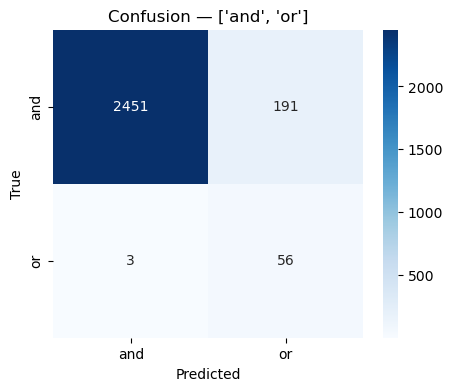


=== Stage 2: CoPE on ['nand', 'nor'] ===
  [Pre2] 1/50, loss: 0.1634
  [Pre2] 25/50, loss: 1.6939
  [Pre2] 50/50, loss: 0.0771
  [Cls2] 1/100, loss: 3.4114
  [Cls2] 50/100, loss: 0.6517
  [Cls2] 100/100, loss: 0.5620
  → Acc group 1 ['and', 'or']: 43.56%
  → Acc group 2 ['nand', 'nor']: 77.24%


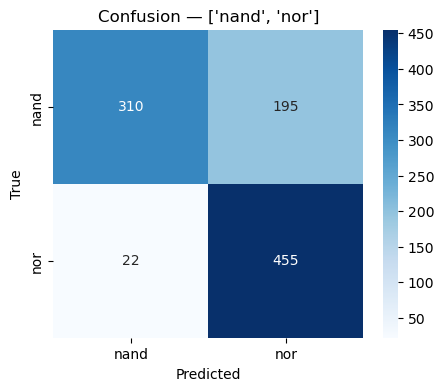


=== Stage 3: CoPE on ['xor'] ===
  [Pre3] 1/50, loss: 1.1953
  [Pre3] 25/50, loss: 131.7518
  [Pre3] 50/50, loss: 2.7590
  [Cls3] 1/100, loss: 55.9213
  [Cls3] 50/100, loss: 0.0048
  [Cls3] 100/100, loss: 0.0014
  → Acc group 1 ['and', 'or']: 26.50%
  → Acc group 2 ['nand', 'nor']: 36.13%
  → Acc group 3 ['xor']: 100.00%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


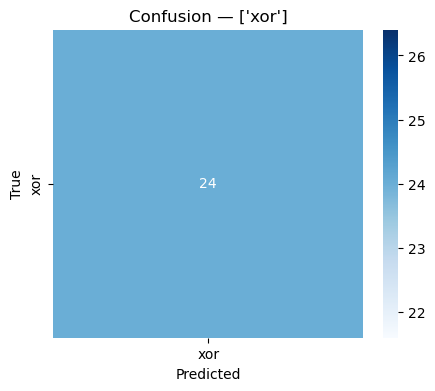


=== Stage 4: CoPE on ['not'] ===
  [Pre4] 1/50, loss: 0.1122
  [Pre4] 25/50, loss: 0.9985
  [Pre4] 50/50, loss: 1.0114
  [Cls4] 1/100, loss: 4.5915
  [Cls4] 50/100, loss: 0.5570
  [Cls4] 100/100, loss: 0.5156
  → Acc group 1 ['and', 'or']: 83.68%
  → Acc group 2 ['nand', 'nor']: 26.45%
  → Acc group 3 ['xor']: 70.83%
  → Acc group 4 ['not']: 78.76%


C:\Users\rrk307\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:395: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


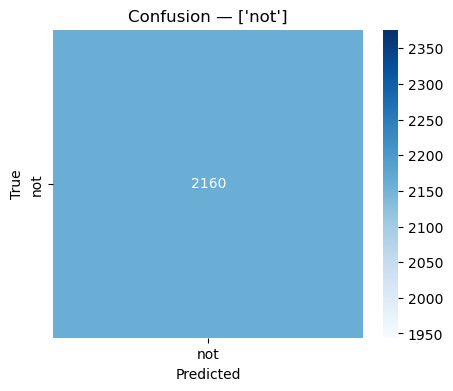


=== Test accuracies per stage & group ===
      group_1 group_2  group_3 group_4
Stage                                 
1      69.49%    nan%     nan%    nan%
2      43.56%  77.24%     nan%    nan%
3      26.50%  36.13%  100.00%    nan%
4      83.68%  26.45%   70.83%  78.76%

=== CoPE: Param Drift vs Forgetting ===
   from_to  param_drift  delta_acc
0  1.0→2.0   216.323035   0.259371
1  1.0→3.0   473.327640   0.429946
2  2.0→3.0   276.692241   0.411060
3  1.0→4.0   684.474915  -0.141912
4  2.0→4.0   479.520423   0.507834
5  3.0→4.0   244.168632   0.291667
Correlation: -0.4961

=== CoPE: CoPE‐Shift vs Forgetting ===
   from_to  cope_shift  delta_acc
0  1.0→2.0    0.339025   0.259371
1  1.0→3.0    0.552581   0.429946
2  2.0→3.0    0.397625   0.411060
3  1.0→4.0    0.578128  -0.141912
4  2.0→4.0    0.465723   0.507834
5  3.0→4.0    0.193400   0.291667
Correlation: -0.2426


In [16]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Load & preprocess data
# ------------------------------------------------
df = pd.read_csv("all_circuits_features.csv")
le = LabelEncoder()
df["gate_label"] = le.fit_transform(df["gate_type"].astype(str))

feat_cols = [
    "fan_in","fan_out","dist_to_output",
    "is_primary_input","is_primary_output","is_internal","is_key_gate",
    "degree_centrality","betweenness_centrality",
    "closeness_centrality","clustering_coefficient",
    "avg_fan_in_neighbors","avg_fan_out_neighbors"
]
df = df.dropna(subset=feat_cols)
df[feat_cols] = StandardScaler().fit_transform(df[feat_cols].astype(float))

nodes = df["node"].tolist()
node2idx = {n: i for i, n in enumerate(nodes)}
N = len(nodes)

# ------------------------------------------------
# 2. Build the DGL graph
# ------------------------------------------------
edges = []
src_cands = df[df["fan_out"] > 0]["node"].tolist()
for _, row in df.iterrows():
    tgt = node2idx[row["node"]]
    for src in src_cands[: int(row["fan_in"])]:
        edges.append((node2idx[src], tgt))
edges = list(set(edges))
src, dst = zip(*edges) if edges else ([], [])
graph = dgl.graph((torch.tensor(src), torch.tensor(dst)), num_nodes=N)
graph = dgl.add_self_loop(graph)
graph.ndata["feat"]  = torch.tensor(df[feat_cols].values, dtype=torch.float32)
graph.ndata["label"] = torch.tensor(df["gate_label"].values, dtype=torch.long)

# ------------------------------------------------
# 3. Define tasks by gate‐type groups
# ------------------------------------------------
group_defs = [
    ["and","or"], ["nand","nor"],
    ["xor","xnor"], ["buf","not"]
]
all_types = set(df["gate_type"])
valid_groups, train_masks, test_masks = [], [], []
for grp in group_defs:
    present = [g for g in grp if g in all_types]
    if not present: continue
    valid_groups.append(present)
    idxs = [node2idx[n] for n in df[df["gate_type"].isin(present)]["node"]]
    strat = df["gate_label"].iloc[idxs]
    tr, te = train_test_split(idxs, test_size=0.2, random_state=42, stratify=strat)
    tm = torch.zeros((N,), dtype=torch.bool); tm[tr] = True
    vm = torch.zeros((N,), dtype=torch.bool); vm[te] = True
    train_masks.append(tm); test_masks.append(vm)

# ------------------------------------------------
# 4. CoPE model with BatchNorm & Dropout
# ------------------------------------------------
class CoPEModel(nn.Module):
    def __init__(self, in_feats, hid, num_cls, drop=0.5):
        super().__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hid, allow_zero_in_degree=True)
        self.bn1   = nn.BatchNorm1d(hid)
        self.conv2 = dglnn.GraphConv(hid,     hid, allow_zero_in_degree=True)
        self.bn2   = nn.BatchNorm1d(hid)
        self.drop  = nn.Dropout(drop)
        self.classifier   = nn.Linear(hid, num_cls)
        self.pretext_head = nn.Linear(hid, in_feats)

    def encode(self, g, x):
        h = F.relu(self.bn1(self.conv1(g, x)))
        h = self.drop(h)
        h = F.relu(self.bn2(self.conv2(g, h)))
        return self.drop(h)

    def forward(self, g, x):
        return self.classifier(self.encode(g, x))

    def reconstruct(self, g, x):
        return self.pretext_head(self.encode(g, x))

# ------------------------------------------------
# 5. CoPE training with snapshotting
# ------------------------------------------------
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = CoPEModel(len(feat_cols), hid=128,
                     num_cls=len(le.classes_), drop=0.4).to(device)
graph    = graph.to(device)
feats    = graph.ndata["feat"]

opt_pre = optim.Adam(
    list(model.conv1.parameters()) + list(model.bn1.parameters()) +
    list(model.conv2.parameters()) + list(model.bn2.parameters()) +
    list(model.pretext_head.parameters()),
    lr=5e-4, weight_decay=1e-5
)
opt_cls = optim.Adam(
    list(model.conv1.parameters()) + list(model.bn1.parameters()) +
    list(model.conv2.parameters()) + list(model.bn2.parameters()) +
    list(model.classifier.parameters()),
    lr=5e-3, weight_decay=1e-5
)

results      = {}
mask_ratio   = 0.2
pre_epochs   = 50
cls_epochs   = 100
num_cls      = len(le.classes_)

# snapshot lists
param_snapshots     = []
pretext_snapshots   = []

# global self‐supervised warm‐up (no snapshot)
print("Global self-supervised pretraining...")
for epoch in range(1, pre_epochs+1):
    model.train()
    masked = feats.clone()
    dims   = np.random.choice(feats.shape[1],
                              int(mask_ratio * feats.shape[1]), replace=False)
    masked[:, dims] = 0
    recon    = model.reconstruct(graph, masked)
    loss_pre = F.mse_loss(recon[:, dims], feats[:, dims])
    opt_pre.zero_grad(); loss_pre.backward(); opt_pre.step()
    if epoch in (1, 25, pre_epochs):
        print(f"  [Global Pre] {epoch}/{pre_epochs}, loss: {loss_pre:.4f}")

# stage‐wise CoPE
for stage, (tr_mask, te_mask, grp) in enumerate(
    zip(train_masks, test_masks, valid_groups), start=1):

    tr_idxs = tr_mask.nonzero().squeeze().tolist()
    te_idxs = te_mask.nonzero().squeeze().tolist()

    print(f"\n=== Stage {stage}: CoPE on {grp} ===")

    # 1) task‐specific self‐supervised pretraining
    for epoch in range(1, pre_epochs+1):
        model.train()
        masked = feats.clone()
        dims   = np.random.choice(feats.shape[1],
                                  int(mask_ratio * feats.shape[1]), replace=False)
        masked[tr_idxs][:, dims] = 0
        recon    = model.reconstruct(graph, masked)
        loss_pre = F.mse_loss(recon[tr_idxs][:, dims], feats[tr_idxs][:, dims])
        opt_pre.zero_grad(); loss_pre.backward(); opt_pre.step()
        if epoch in (1, 25, pre_epochs):
            print(f"  [Pre{stage}] {epoch}/{pre_epochs}, loss: {loss_pre:.4f}")

    # 2) supervised fine‐tuning
    label_tr = graph.ndata["label"][tr_mask].to(device)
    counts   = torch.bincount(label_tr, minlength=num_cls).float()
    weights  = (label_tr.numel() / (counts * num_cls)).clamp(max=10.0)
    weights[counts == 0] = 0.0
    criterion = nn.CrossEntropyLoss(weight=weights)

    for epoch in range(1, cls_epochs+1):
        model.train()
        logits = model(graph, feats)
        loss   = criterion(logits[tr_idxs], label_tr)
        opt_cls.zero_grad(); loss.backward(); opt_cls.step()
        if epoch in (1, 50, cls_epochs):
            print(f"  [Cls{stage}] {epoch}/{cls_epochs}, loss: {loss:.4f}")

    # 3) evaluation
    model.eval()
    with torch.no_grad():
        logits  = model(graph, feats).cpu().numpy()
        preds   = logits.argmax(axis=1)
        results[stage] = {}
        for i in range(stage):
            idxs = test_masks[i].nonzero().squeeze().cpu().numpy()
            acc  = accuracy_score(
                graph.ndata["label"][idxs].cpu().numpy(), preds[idxs]
            )
            results[stage][f"group_{i+1}"] = acc
            print(f"  → Acc group {i+1} {valid_groups[i]}: {acc*100:.2f}%")

        # confusion
        cm = confusion_matrix(
            graph.ndata["label"][te_idxs].cpu().numpy(),
            preds[te_idxs],
            labels=le.transform(grp)
        )
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=grp, yticklabels=grp)
        plt.title(f"Confusion — {grp}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.show()

    # --- snapshots after stage ---
    # 1) full parameters θ^(stage)
    param_snapshots.append({
        name: param.clone().detach().cpu()
        for name, param in model.state_dict().items()
    })
    # 2) pretext‐head parameters f_self^(stage)
    pretext_snapshots.append({
        name: param.clone().detach().cpu()
        for name, param in model.pretext_head.state_dict().items()
    })

# ------------------------------------------------
# 6. Results summary
# ------------------------------------------------
df_res = pd.DataFrame(results).T
df_res.index.name = "Stage"
print("\n=== Test accuracies per stage & group ===")
print(df_res.applymap(lambda v: f"{v*100:5.2f}%"))

# ------------------------------------------------
# 7. Interpretability Dashboard for CoPE
# ------------------------------------------------

# A) Parameter‐Drift vs Forgetting
drift_records = []
for t in range(2, len(param_snapshots)+1):
    θ_t = param_snapshots[t-1]
    for k in range(1, t):
        θ_k = param_snapshots[k-1]
        sq   = 0.0
        for name in θ_k:
            d   = θ_t[name] - θ_k[name]
            sq += d.pow(2).sum().item()
        drift = np.sqrt(sq)
        delta = results[k][f"group_{k}"] - results[t][f"group_{k}"]
        drift_records.append({
            "from_task": k, "to_task": t,
            "param_drift": drift, "delta_acc": delta
        })
drift_df = pd.DataFrame(drift_records)
drift_df["from_to"] = drift_df.apply(lambda r: f"{r.from_task}→{r.to_task}", axis=1)
print("\n=== CoPE: Param Drift vs Forgetting ===")
print(drift_df[["from_to","param_drift","delta_acc"]])
print(f"Correlation: {drift_df.param_drift.corr(drift_df.delta_acc):.4f}")

# B) CoPE‐Shift vs Forgetting (pretext‐head drift)
cope_records = []
for t in range(2, len(pretext_snapshots)+1):
    head_t = pretext_snapshots[t-1]
    for k in range(1, t):
        head_k = pretext_snapshots[k-1]
        sq     = 0.0
        for name in head_k:
            d   = head_t[name] - head_k[name]
            sq += d.pow(2).sum().item()
        shift = np.sqrt(sq)
        delta = results[k][f"group_{k}"] - results[t][f"group_{k}"]
        cope_records.append({
            "from_task": k, "to_task": t,
            "cope_shift": shift, "delta_acc": delta
        })
cope_df = pd.DataFrame(cope_records)
cope_df["from_to"] = cope_df.apply(lambda r: f"{r.from_task}→{r.to_task}", axis=1)
print("\n=== CoPE: CoPE‐Shift vs Forgetting ===")
print(cope_df[["from_to","cope_shift","delta_acc"]])
print(f"Correlation: {cope_df.cope_shift.corr(cope_df.delta_acc):.4f}")
